# Attention Mechanism

# RNN recap

In a basic RNN, each recurrent neuron receives inputs from all neurons from the previous time step, as well as the inputs from the current time step, hence the term 'recurrent'.

In [11]:
### This cell should be hidden in the final version

import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.src.utils import pad_sequences
from jupyterquiz import display_quiz
from sklearn.metrics import accuracy_score
from keras.datasets import imdb


git_path="https://raw.githubusercontent.com/ChaosTheLegend/ML-Book/main/Quizes/"

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=10000)

max_len = 200
x_train = pad_sequences(x_train, maxlen=max_len, truncating='post')
x_test = pad_sequences(x_test, maxlen=max_len, truncating='post')
num_words = 10000

embedding_dim = 100
hidden_dim = 256
output_dim = 1
dropout_rate = 0.5

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_len),
    tf.keras.layers.SimpleRNN(hidden_dim),
    tf.keras.layers.Dense(output_dim, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

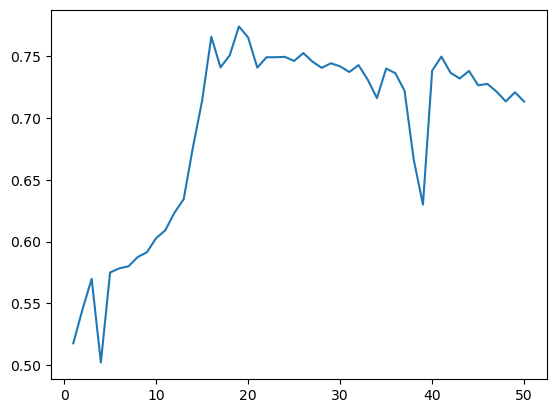

In [17]:
accuracy_epochs = pd.read_csv('simplernn_accuracy.csv')

plt.plot(accuracy_epochs['epoch'], accuracy_epochs['accuracy'])

In [5]:
simpleRNN = tf.keras.models.load_model('simpleRNN.keras')

simpleRNN.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 200, 100)          1000000   
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 256)               91392     
                                                                 
 dense_15 (Dense)            (None, 1)                 257       
                                                                 
Total params: 1091649 (4.16 MB)
Trainable params: 1091649 (4.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# make predictions and calculate accuracy

y_pred = simpleRNN.predict(x_test)
y_pred = np.round(y_pred)

accuracy = accuracy_score(y_test, y_pred)

782/782 [==============================] - 11s 14ms/step


In [18]:
accuracy

0.71312

## The Need for Attention Mechanism

The problem with basic RNNs is that they are not very good at handling long sequences. 

Even when using more epochs, the accuracy of the model does not improve much. This is because the model is not able to learn the long-term dependencies in the data.

This is known as the vanishing gradient problem.

### Vanishing Gradient Problem

The vanishing gradient problem occurs when the gradients of the loss function become increasingly smaller as the model learns to associate inputs and outputs that are further apart in time.

This leads to the model "forgetting" the information from the earlier inputs, which makes it difficult to learn long-term dependencies.

![Simple RNN](https://raw.githubusercontent.com/ChaosTheLegend/ML-Book/main/Images/SimpleRNN.png)

### Math Behind Vanishing Gradient Problem

The vanishing gradient problem occurs because of the way gradients are computed in RNNs:

$$
\frac{\partial L}{\partial W} = \frac{\partial L}{\partial y} \frac{\partial y}{\partial h} \frac{\partial h}{\partial W}
$$

The gradient is computed by multiplying the gradients of the loss function with respect to the output, the output with respect to the hidden state, and the hidden state with respect to the weights.

Since gradients are multiplied together, if the gradients at each time step are less than 1 (e.g., due to using activation functions like sigmoid or tanh), this multiplication leads to a compounding effect. As you go further back in time, the gradients become increasingly smaller.


![Simple RNN](https://raw.githubusercontent.com/ChaosTheLegend/ML-Book/main/Images/SimpleRNNProblem.png)

## Attention Mechanism

To combat the vanishing gradient problem, we can use an attention mechanism.

An attention mechanism is a way to help RNNs learn long-term dependencies by allowing the model to focus on the most relevant parts of the input sequence when producing a given output.

We do this by adding a context vector to the model, which is a weighted sum of the encoder's hidden states. The weights are computed using an alignment score function, which measures how well the inputs around a given position and the output at that position match.

![Attention Mechanism](https://raw.githubusercontent.com/ChaosTheLegend/ML-Book/main/Images/Attention.png)

In [35]:
from keras.layers import Input, Embedding, LSTM, Dense, Attention, Bidirectional, Dropout
import os

#check if there is a model file in the current directory

# if not, train a new model and save it

# if there is, load the model from the file

train_new_model = True

if('LSTM.keras' in os.listdir()):
    LSTM = tf.keras.models.load_model('LSTM.keras')
    train_new_model = False


In [ ]:
if train_new_model:    
    inputs = Input(shape=(max_len,))
    embedding = Embedding(input_dim=10000, output_dim=embedding_dim, input_length=max_len)(inputs)
    lstm = Bidirectional(LSTM(hidden_dim, return_sequences=True))(embedding)
    attention = Attention()([lstm, lstm])
    context = tf.reduce_sum(attention * lstm, axis=1)
    dropout = Dropout(dropout_rate)(context)
    output = Dense(output_dim, activation='sigmoid')(dropout)


    LSTM = tf.keras.Model(inputs=inputs, outputs=output)

    LSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [62]:
LSTM.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 200, 100)             1000000   ['input_1[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 200, 512)             731136    ['embedding_5[0][0]']         
 al)                                                                                              
                                                                                                  
 attention (Attention)       (None, 200, 512)             0         ['bidirectional[0][0]',   

In [64]:
if train_new_model:
    LSTM.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.2)

Epoch 1/5
157/157 [==============================] - 500s 3s/step - loss: 0.3923 - accuracy: 0.8305 - val_loss: 0.3380 - val_accuracy: 0.8576
Epoch 2/5
157/157 [==============================] - 384s 2s/step - loss: 0.2301 - accuracy: 0.9102 - val_loss: 0.3628 - val_accuracy: 0.8676
Epoch 3/5
157/157 [==============================] - 402s 3s/step - loss: 0.1718 - accuracy: 0.9337 - val_loss: 0.3564 - val_accuracy: 0.8626
Epoch 4/5
157/157 [==============================] - 401s 3s/step - loss: 0.1479 - accuracy: 0.9424 - val_loss: 0.4766 - val_accuracy: 0.8486
Epoch 5/5
157/157 [==============================] - 400s 3s/step - loss: 0.1057 - accuracy: 0.9574 - val_loss: 0.5865 - val_accuracy: 0.8534


In [66]:
LSTM.save('LSTM.keras')

In [86]:
y_pred = LSTM.predict(x_test)

y_pred = np.round(y_pred)

accuracy = accuracy_score(y_test, y_pred)

accuracy

782/782 [==============================] - 108s 139ms/step


0.82268

In [36]:
LSTM.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 200, 100)             1000000   ['input_1[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 200, 512)             731136    ['embedding_5[0][0]']         
 al)                                                                                              
                                                                                                  
 attention (Attention)       (None, 200, 512)             0         ['bidirectional[0][0]',   

## Alignment Scores in RNN Attention Mechanism

The attention mechanism in a recurrent neural network (RNN) uses alignment scores to determine how much focus to place on each input in a sequence.

In the context of sequence-to-sequence models, for example, if we have an encoded input sequence, an alignment score is computed for each pair of input and output positions. If "a" is the decoder’s hidden state and "b" is all of the encoder’s hidden states, the alignment score function often takes the following form:

$$
\text{score}(a, b) = a^Tb
$$

This score indicates how well the inputs around position "b" and the output at position "a" match. The alignment scores for each input "b" are combined into a single vector and normalized to sum to 1, resulting in the attention weights. These weights determine the amount of 'attention' given by the model to each input timestep while producing an output. 

Higher alignment scores mean that the decoder pays more attention to those parts of the encoder's output.

Overall, the attention mechanism improves the accuracy of the RNN model when handling tasks with long input sequences, by enabling it to focus on the most relevant parts of the input to produce a given output.

## From Alignment Scores to Attention Weights

After computing the alignment scores between the input and output vectors in the attention mechanism, these scores are then converted to attention weights using the softmax function.

The softmax function is commonly used in neural networks to turn scores into probabilities. It is defined as:

$$
\text{softmax}(x_i) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}
$$

By applying softmax, we ensure that each weight falls in the range [0, 1] and that they all sum to 1, which allows us to interpret the attention weights as probabilities.

In the context of attention mechanisms, the softmax function is applied to the alignment scores for each input and output pair, resulting in attention weights. Therefore, each input element in a sequence gets an attention weight. Now the model knows how much attention it needs to pay to each element when encoding information.

For a given output, positions in the input sequence with a higher attention weight have a greater influence on the computation. This means our decoder will "pay more attention" to these positions during the encoding of the sequence.